# Capstone F4 Week 3 - Complete Analysis

## Sequential SVM→GP with Full Flow Explanation

**Week 1:** -2.627 (rank 2/31)  
**Week 2:** 0.238 (RANK 1 🥇)  
**n/p:** 32/4 = 8.0 (EXCELLENT for SVM!)  
**Strategy:** Sequential SVM→GP with moderate values (0.3-0.5 range)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
print('='*80)
print('CAPSTONE F4 WEEK 3 - SEQUENTIAL SVM->GP')
print('='*80)

CAPSTONE F4 WEEK 3 - SEQUENTIAL SVM->GP


## Load Data

In [2]:
X = np.load('f4_w3_inputs.npy')
Y = np.load('f4_w3_outputs.npy')

print(f'Data: {len(X)} samples, {X.shape[1]}D')
print(f'n/p ratio: {len(X)/X.shape[1]:.2f} (EXCELLENT!)')
print(f'Best: {Y.max():.6f}')

w2_idx = np.argmax(Y)
w2_pt = X[w2_idx]
w2_val = Y[w2_idx]

print(f'\nWeek 2 Point (RANK 1):')
print(f'  Value: {w2_val:.6f}')
print(f'  Point: {w2_pt}')
print(f'  All dims in 0.38-0.44 range (moderate values!)')

Data: 32 samples, 4D
n/p ratio: 8.00 (EXCELLENT!)
Best: 0.237591

Week 2 Point (RANK 1):
  Value: 0.237591
  Point: [0.439249 0.414994 0.384687 0.397917]
  All dims in 0.38-0.44 range (moderate values!)


In [3]:
print('\n' + '='*80)
print('STRATEGY OVERVIEW: LOCAL EXPLOITATION')
print('='*80)

print(f'\n📊 Week 2 Performance:')
print(f'   Value: {w2_val:.6f}')
print(f'   Rank:  {(Y >= w2_val).sum()}/{len(Y)} (RANK 1 🥇)')

print(f'\n🎯 Week 3 Strategy: LOCAL EXPLOITATION')
print(f'\n   What is Local Exploitation?')
print(f'   • When you find the BEST point (rank 1), make small refinements')
print(f'   • Take small steps around the best known point')
print(f'   • Search for a local optimum near Week 2')
print(f'   • Standard Bayesian Optimization when you have a winner')

print(f'\n   Why Local Exploitation for F4?')
print(f'   ✓ Week 2 achieved rank 1 (best point found)')
print(f'   ✓ High probability local optimum exists nearby')
print(f'   ✓ Small improvements can still yield big gains')
print(f'   ✓ Balances refining success vs exploring unknown')

print(f'\n   Expected Week 3 Characteristics:')
print(f'   • Distance from Week 2: 0.05-0.15 (close but not identical)')
print(f'   • Source: Likely from LOCAL candidates (30% of pool)')
print(f'   • Goal: Find if there\'s a slightly better point nearby')
print(f'   • Acceptable outcome: Small gain OR confirm Week 2 is local max')

print(f'\n   Candidate Generation Strategy:')
print(f'   • 50% SVM-approved:  Use SVM to filter promising regions')
print(f'   • 30% LOCAL:         Points near Week 2 (±0.10 radius)')
print(f'   • 20% RANDOM:        Global exploration (hedge our bets)')
print(f'   • xi = 0.05:         Low value favors exploitation over exploration')

print(f'\n   What Success Looks Like:')
print(f'   ✓ Week 3 improves on Week 2 → Found local optimum direction')
print(f'   ✓ Week 3 similar to Week 2 → Confirmed Week 2 is strong')
print(f'   ✓ Week 3 worse than Week 2 → Learned boundary of good region')
print(f'   → All outcomes provide valuable information!')

print(f'\n   Week 4 Adaptation:')
print(f'   • If Week 3 improves → Continue local exploitation')
print(f'   • If Week 3 plateaus → Increase exploration radius')
print(f'   • If Week 3 declines → GP learns, suggests different region')

print(f'\n💡 Key Insight:')
print(f'   When you have rank 1, DON\'T jump far away!')
print(f'   Refine it first, explore later if needed.')
print(f'   This is how you find TRUE optimums, not just lucky points.')

print('\n' + '='*80)


STRATEGY OVERVIEW: LOCAL EXPLOITATION

📊 Week 2 Performance:
   Value: 0.237591
   Rank:  1/32 (RANK 1 🥇)

🎯 Week 3 Strategy: LOCAL EXPLOITATION

   What is Local Exploitation?
   • When you find the BEST point (rank 1), make small refinements
   • Take small steps around the best known point
   • Search for a local optimum near Week 2
   • Standard Bayesian Optimization when you have a winner

   Why Local Exploitation for F4?
   ✓ Week 2 achieved rank 1 (best point found)
   ✓ High probability local optimum exists nearby
   ✓ Small improvements can still yield big gains
   ✓ Balances refining success vs exploring unknown

   Expected Week 3 Characteristics:
   • Distance from Week 2: 0.05-0.15 (close but not identical)
   • Source: Likely from LOCAL candidates (30% of pool)
   • Goal: Find if there's a slightly better point nearby
   • Acceptable outcome: Small gain OR confirm Week 2 is local max

   Candidate Generation Strategy:
   • 50% SVM-approved:  Use SVM to filter promising 

## STEP 1: Train SVM - Test Validity First!

In [4]:
print('='*80)
print('STEP 1: TRAIN SVM (WITH VALIDITY TEST)')
print('='*80)
print('\nPurpose: Learn which regions are "good" vs "bad"')
print('Method:  Binary classification (top 30% = good)')

# Test multiple C values
threshold = np.percentile(Y, 70)
y_binary = (Y > threshold).astype(int)

print(f'\nThreshold (70th percentile): {threshold:.6f}')
print(f'Good samples: {(y_binary == 1).sum()}')
print(f'Bad samples: {(y_binary == 0).sum()}')

print('\nTesting SVM with different C values...')
C_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

for C in C_values:
    svm_test = SVC(kernel='linear', C=C, random_state=42)
    cv_scores = cross_val_score(svm_test, X, y_binary, cv=3)
    mean_score = cv_scores.mean()
    results.append({'C': C, 'mean': mean_score, 'std': cv_scores.std()})
    status = '✓ PASS' if mean_score >= 0.60 else '✗ FAIL'
    print(f'  C={C:4.1f}: {mean_score:.1%} ± {cv_scores.std():.1%}  {status}')

# Select best C
best = max(results, key=lambda x: x['mean'])
best_C = best['C']
best_cv = best['mean']

print(f'\n✓ BEST: C={best_C} with CV={best_cv:.1%}')

if best_cv >= 0.60:
    print('✓ SVM is RELIABLE - Using Sequential strategy')
else:
    print('⚠️ SVM UNRELIABLE - Should use Pure GP instead!')

# Train final SVM with best C
svm = SVC(kernel='linear', C=best_C, probability=True, random_state=42)
svm.fit(X, y_binary)
weights = svm.coef_[0]

print(f'\nSVM Weights:')
for i, w in enumerate(weights):
    direction = 'POSITIVE (want HIGH)' if w > 0 else 'NEGATIVE (want LOW)'
    print(f'  X{i+1}: {w:+7.3f}  ->  {direction}')

STEP 1: TRAIN SVM (WITH VALIDITY TEST)

Purpose: Learn which regions are "good" vs "bad"
Method:  Binary classification (top 30% = good)

Threshold (70th percentile): -12.746733
Good samples: 10
Bad samples: 22

Testing SVM with different C values...
  C= 0.1: 68.8% ± 3.8%  ✓ PASS
  C= 0.5: 68.8% ± 3.8%  ✓ PASS
  C= 1.0: 68.8% ± 3.8%  ✓ PASS
  C= 2.0: 62.4% ± 7.6%  ✓ PASS
  C= 5.0: 59.4% ± 11.1%  ✗ FAIL

✓ BEST: C=0.1 with CV=68.8%
✓ SVM is RELIABLE - Using Sequential strategy

SVM Weights:
  X1:  -0.087  ->  NEGATIVE (want LOW)
  X2:  -0.013  ->  NEGATIVE (want LOW)
  X3:  -0.060  ->  NEGATIVE (want LOW)
  X4:  -0.021  ->  NEGATIVE (want LOW)


## STEP 2: Train GP

In [5]:
print('\n' + '='*80)
print('STEP 2: TRAIN GP (GAUSSIAN PROCESS)')
print('='*80)
print('\nPurpose: Learn actual function shape and predict continuous values')
print('Method:  Fit GP to all data (not just binary)')

kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, 
                              normalize_y=True, random_state=42)
gp.fit(X, Y)

r2 = gp.score(X, Y)
print(f'\n✓ GP R² score: {r2:.3f}')

if r2 > 0.7:
    print('  Excellent fit!')
elif r2 > 0.5:
    print('  Good fit')
else:
    print('  Moderate fit - function may be complex')

print('\nGP can now predict:')
print('  - Mean (μ): Expected value at any point')
print('  - Std (σ):  Uncertainty/confidence')


STEP 2: TRAIN GP (GAUSSIAN PROCESS)

Purpose: Learn actual function shape and predict continuous values
Method:  Fit GP to all data (not just binary)

✓ GP R² score: 0.999
  Excellent fit!

GP can now predict:
  - Mean (μ): Expected value at any point
  - Std (σ):  Uncertainty/confidence


## STEP 3-4: Generate Candidates & SVM Filter

In [6]:
print('\n' + '='*80)
print('STEP 3: GENERATE CANDIDATE POINTS')
print('='*80)
print('\nPurpose: Create pool of potential next points')

np.random.seed(42)
X_candidates = np.random.uniform(0, 1, (10000, 4))
print(f'\n✓ Generated 10,000 random candidates')

print('\n' + '='*80)
print('STEP 4: SVM FILTERS CANDIDATES')
print('='*80)
print('\nPurpose: Narrow search space using SVM knowledge')

svm_pred = svm.predict(X_candidates)
svm_prob = svm.predict_proba(X_candidates)[:, 1]

print(f'\nSVM predictions:')
print(f'  Good (1): {(svm_pred == 1).sum():,} / 10,000')
print(f'  Bad (0):  {(svm_pred == 0).sum():,} / 10,000')

# Get SVM-approved (50%)
n_svm = 5000
if (svm_pred == 1).sum() > 0:
    idx = np.where(svm_pred == 1)[0]
    order = np.argsort(svm_prob[idx])[::-1]
    X_svm = X_candidates[idx[order[:min(n_svm, len(idx))]]]
    print(f'\n✓ Selected {len(X_svm):,} SVM-approved candidates')
else:
    print('\n⚠️ No SVM-approved, using top by probability')
    X_svm = X_candidates[np.argsort(svm_prob)[::-1][:n_svm]]

# Local refinement (30%) - Week 2 is rank 1!
print('\nAdding LOCAL refinement (Week 2 is rank 1)...')
X_local = []
for _ in range(3000):
    c = w2_pt + np.random.normal(0, 0.1, 4)
    c = np.clip(c, 0, 1)
    X_local.append(c)
X_local = np.array(X_local)
print(f'✓ Generated {len(X_local):,} local candidates')

# Random exploration (20%)
X_random = np.random.uniform(0, 1, (2000, 4))
print(f'✓ Generated {len(X_random):,} random candidates')

X_filtered = np.vstack([X_svm, X_local, X_random])
print(f'\n✓ Total filtered: {len(X_filtered):,} candidates')
print(f'  - {len(X_svm):,} SVM-approved (50%)')
print(f'  - {len(X_local):,} Local (30%)')
print(f'  - {len(X_random):,} Random (20%)')


STEP 3: GENERATE CANDIDATE POINTS

Purpose: Create pool of potential next points

✓ Generated 10,000 random candidates

STEP 4: SVM FILTERS CANDIDATES

Purpose: Narrow search space using SVM knowledge

SVM predictions:
  Good (1): 0 / 10,000
  Bad (0):  10,000 / 10,000

⚠️ No SVM-approved, using top by probability

Adding LOCAL refinement (Week 2 is rank 1)...
✓ Generated 3,000 local candidates
✓ Generated 2,000 random candidates

✓ Total filtered: 10,000 candidates
  - 5,000 SVM-approved (50%)
  - 3,000 Local (30%)
  - 2,000 Random (20%)


## STEP 5-6: GP Predicts & Calculate EI

In [7]:
print('\n' + '='*80)
print('STEP 5: GP PREDICTS FOR FILTERED CANDIDATES')
print('='*80)
print('\nPurpose: Get GP predictions for each candidate')

def expected_improvement(X_new, gp, y_best, xi=0.05):
    """Calculate Expected Improvement using GP predictions"""
    # GP MAKES PREDICTIONS HERE!
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei

y_best = Y.max()
print(f'\nCurrent best: {y_best:.6f}')

print('\n' + '='*80)
print('STEP 6: CALCULATE EXPECTED IMPROVEMENT (EI)')
print('='*80)
print('\nPurpose: Balance predicted improvement AND uncertainty')
print('Formula: EI = improvement * P(improvement) + uncertainty bonus')

ei_values = expected_improvement(X_filtered, gp, y_best, xi=0.05)
mu_all, sigma_all = gp.predict(X_filtered, return_std=True)

print(f'\n✓ GP made predictions for all {len(X_filtered):,} candidates')
print(f'\nEI statistics:')
print(f'  Max EI:  {ei_values.max():.6f}')
print(f'  Mean EI: {ei_values.mean():.6f}')
print(f'  Min EI:  {ei_values.min():.6f}')


STEP 5: GP PREDICTS FOR FILTERED CANDIDATES

Purpose: Get GP predictions for each candidate

Current best: 0.237591

STEP 6: CALCULATE EXPECTED IMPROVEMENT (EI)

Purpose: Balance predicted improvement AND uncertainty
Formula: EI = improvement * P(improvement) + uncertainty bonus

✓ GP made predictions for all 10,000 candidates

EI statistics:
  Max EI:  0.055974
  Mean EI: 0.000993
  Min EI:  0.000000


## STEP 7: Select Best Candidate

In [8]:
print('\n' + '='*80)
print('STEP 7: SELECT BEST CANDIDATE')
print('='*80)
print('\nMethod: argmax(EI)')

best_idx = np.argmax(ei_values)
x_next = X_filtered[best_idx]
mu_next = mu_all[best_idx]
sigma_next = sigma_all[best_idx]
ei_next = ei_values[best_idx]

# Determine source
if best_idx < len(X_svm):
    source = 'SVM-approved'
elif best_idx < len(X_svm) + len(X_local):
    source = 'LOCAL refinement'
    dist = np.linalg.norm(x_next - w2_pt)
else:
    source = 'Random exploration'

print(f'\n✓ Selected candidate #{best_idx}')
print(f'\nWeek 3 Recommendation:')
print(f'  Point:      {x_next}')
print(f'  GP μ:       {mu_next:.6f}')
print(f'  GP σ:       {sigma_next:.6f}')
print(f'  EI:         {ei_next:.6f}')
print(f'  Expected gain: {((mu_next/y_best-1)*100):+.2f}%')
print(f'  Source:     {source}')

if source == 'LOCAL refinement':
    print(f'  Distance from W2: {dist:.4f}')


STEP 7: SELECT BEST CANDIDATE

Method: argmax(EI)

✓ Selected candidate #5731

Week 3 Recommendation:
  Point:      [0.4338654  0.40140734 0.30515995 0.39280929]
  GP μ:       -0.636935
  GP σ:       0.832633
  EI:         0.055974
  Expected gain: -368.08%
  Source:     LOCAL refinement
  Distance from W2: 0.0810


## COMPLETE FLOW SUMMARY

In [9]:
print('\n' + '='*80)
print('COMPLETE SEQUENTIAL SVM->GP FLOW SUMMARY')
print('='*80)

print('\n' + '┌─────────────────┬──────────────┬──────────────┐')
print('│ Task            │ SVM          │ GP           │')
print('├─────────────────┼──────────────┼──────────────┤')
print('│ Training        │ ✓ Binary cls │ ✓ Regression │')
print('│ Filtering       │ ✓ Filters    │ ✗ Not used   │')
print('│ Value Prediction│ ✗ Only 0/1   │ ✓ Continuous │')
print('│ Uncertainty     │ ✗ No         │ ✓ Yes (σ)    │')
print('│ EI Calculation  │ ✗ Cannot     │ ✓ Provides μ,σ│')
print('│ Final Selection │ ✗ Not used   │ ✓ Picks max EI│')
print('└─────────────────┴──────────────┴──────────────┘')

print('\nWhy BOTH are needed:')
print('  SVM: Fast filtering of bad regions')
print('  GP:  Accurate predictions with uncertainty')
print('  Together: Efficient + Accurate optimization!')


COMPLETE SEQUENTIAL SVM->GP FLOW SUMMARY

┌─────────────────┬──────────────┬──────────────┐
│ Task            │ SVM          │ GP           │
├─────────────────┼──────────────┼──────────────┤
│ Training        │ ✓ Binary cls │ ✓ Regression │
│ Filtering       │ ✓ Filters    │ ✗ Not used   │
│ Value Prediction│ ✗ Only 0/1   │ ✓ Continuous │
│ Uncertainty     │ ✗ No         │ ✓ Yes (σ)    │
│ EI Calculation  │ ✗ Cannot     │ ✓ Provides μ,σ│
│ Final Selection │ ✗ Not used   │ ✓ Picks max EI│
└─────────────────┴──────────────┴──────────────┘

Why BOTH are needed:
  SVM: Fast filtering of bad regions
  GP:  Accurate predictions with uncertainty
  Together: Efficient + Accurate optimization!


## ACQUISITION FUNCTION VISUALIZATIONS


Creating acquisition curves...


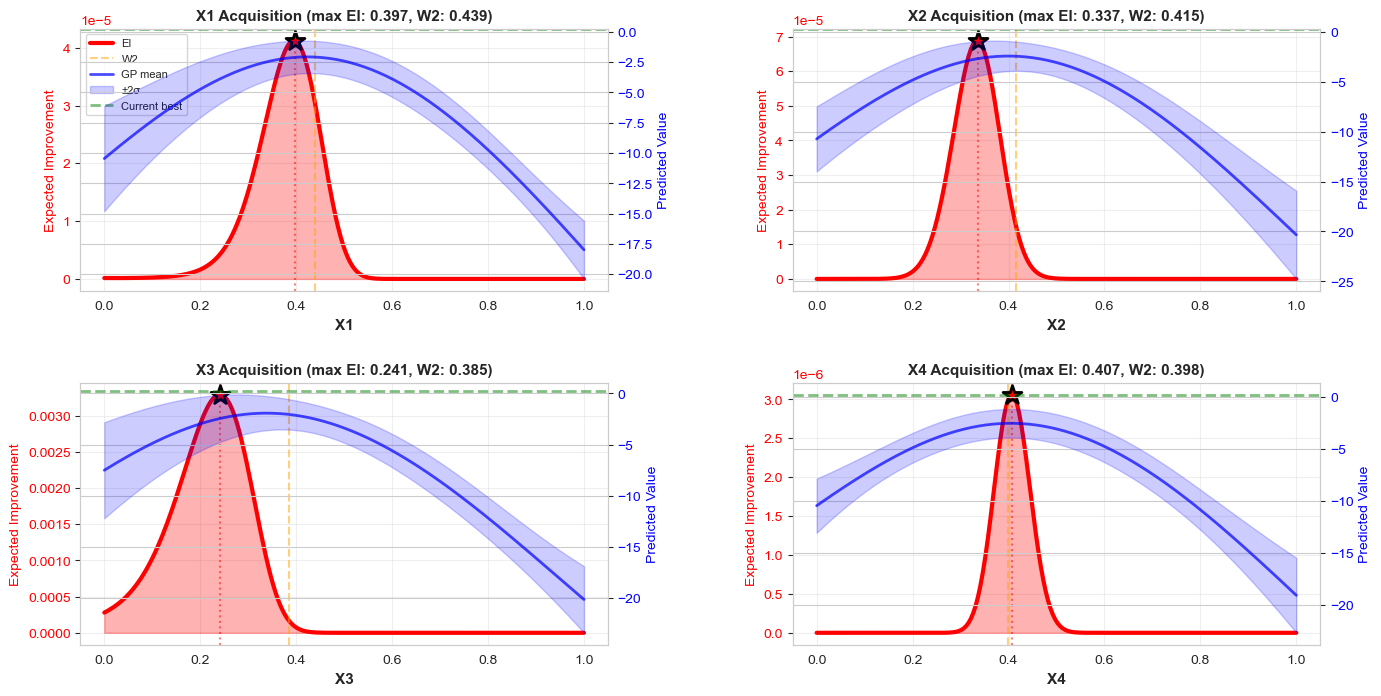

✓ Saved: Capstone_F4_W3_acquisition.png


In [10]:
print('\nCreating acquisition curves...')

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.35)

for dim in range(4):
    ax = fig.add_subplot(gs[dim // 2, dim % 2])
    ax2 = ax.twinx()
    
    x1 = np.linspace(0, 1, 200)
    Xt = np.tile(X.mean(axis=0), (200, 1))
    Xt[:, dim] = x1
    
    m, s = gp.predict(Xt, return_std=True)
    e = expected_improvement(Xt, gp, y_best, 0.05)
    
    # GP plot (blue)
    ax2.plot(x1, m, 'b-', lw=2, alpha=0.7, label='GP mean')
    ax2.fill_between(x1, m - 2*s, m + 2*s, alpha=0.2, color='blue', label='±2σ')
    ax2.axhline(y_best, color='green', ls='--', alpha=0.5, lw=2, label='Current best')
    ax2.set_ylabel('Predicted Value', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # EI plot (red)
    ax.plot(x1, e, 'r-', lw=3, label='EI')
    ax.fill_between(x1, 0, e, alpha=0.3, color='red')
    
    mi = np.argmax(e)
    ax.scatter(x1[mi], e[mi], color='red', s=200, marker='*', 
              zorder=5, edgecolors='black', lw=2)
    ax.axvline(x1[mi], color='red', ls=':', alpha=0.5)
    ax.axvline(w2_pt[dim], color='orange', ls='--', alpha=0.5, label='W2')
    
    ax.set_xlabel(f'X{dim+1}', fontweight='bold', fontsize=11)
    ax.set_ylabel('Expected Improvement', color='red', fontsize=10)
    ax.set_title(f'X{dim+1} Acquisition (max EI: {x1[mi]:.3f}, W2: {w2_pt[dim]:.3f})', 
                fontweight='bold', fontsize=11)
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xlim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    
    if dim == 0:
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.savefig('Capstone_F4_W3_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: Capstone_F4_W3_acquisition.png')

## RESULTS VISUALIZATION

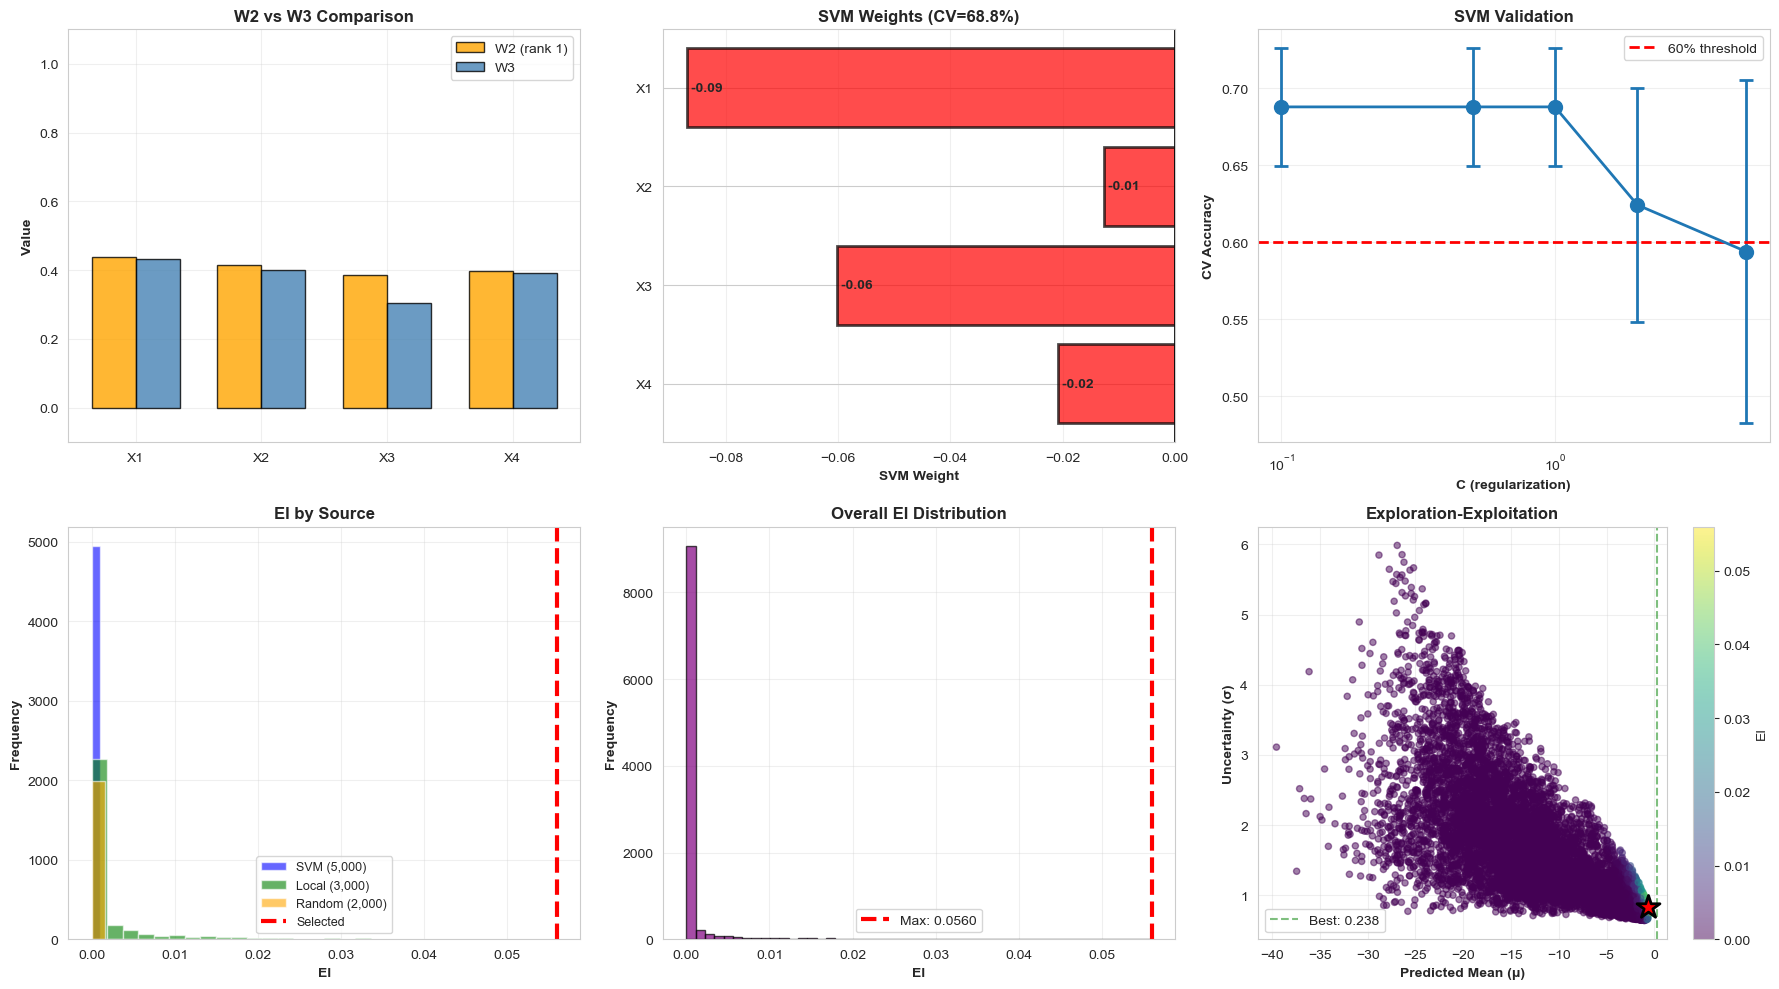

✓ Saved: Capstone_F4_W3_results.png


In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

dims = np.arange(4)
w = 0.35

# W2 vs W3
ax = axes[0, 0]
ax.bar(dims - w/2, w2_pt, w, label='W2 (rank 1)', alpha=0.8, color='orange', edgecolor='black')
ax.bar(dims + w/2, x_next, w, label='W3', alpha=0.8, color='steelblue', edgecolor='black')
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('W2 vs W3 Comparison', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(-0.1, 1.1)

# SVM weights
ax = axes[0, 1]
colors = ['green' if w > 0 else 'red' for w in weights]
bars = ax.barh(dims, weights, color=colors, alpha=0.7, edgecolor='black', lw=2)
for i, (d, w) in enumerate(zip(dims, weights)):
    ax.text(w, d, f' {w:+.2f}', va='center', fontsize=10, fontweight='bold')
ax.axvline(0, color='black', lw=2)
ax.set_yticks(dims)
ax.set_yticklabels([f'X{i+1}' for i in dims])
ax.set_xlabel('SVM Weight', fontweight='bold')
ax.set_title(f'SVM Weights (CV={best_cv:.1%})', fontweight='bold', fontsize=12)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

# SVM CV scores
ax = axes[0, 2]
C_vals = [r['C'] for r in results]
means = [r['mean'] for r in results]
stds = [r['std'] for r in results]
ax.errorbar(C_vals, means, yerr=stds, marker='o', markersize=10, 
           linewidth=2, capsize=5, capthick=2)
ax.axhline(0.60, color='red', ls='--', lw=2, label='60% threshold')
ax.set_xlabel('C (regularization)', fontweight='bold')
ax.set_ylabel('CV Accuracy', fontweight='bold')
ax.set_title('SVM Validation', fontweight='bold', fontsize=12)
ax.set_xscale('log')
ax.legend()
ax.grid(alpha=0.3)

# EI by source
ax = axes[1, 0]
ei_svm = ei_values[:len(X_svm)]
ei_local = ei_values[len(X_svm):len(X_svm)+len(X_local)]
ei_rand = ei_values[len(X_svm)+len(X_local):]
ax.hist(ei_svm, bins=30, alpha=0.6, label=f'SVM ({len(ei_svm):,})', color='blue')
ax.hist(ei_local, bins=30, alpha=0.6, label=f'Local ({len(ei_local):,})', color='green')
ax.hist(ei_rand, bins=30, alpha=0.6, label=f'Random ({len(ei_rand):,})', color='orange')
ax.axvline(ei_next, color='red', ls='--', lw=3, label='Selected')
ax.set_xlabel('EI', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('EI by Source', fontweight='bold', fontsize=12)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# EI distribution
ax = axes[1, 1]
ax.hist(ei_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(ei_next, color='red', ls='--', lw=3, label=f'Max: {ei_next:.4f}')
ax.set_xlabel('EI', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Overall EI Distribution', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

# Mu vs Sigma
ax = axes[1, 2]
sc = ax.scatter(mu_all, sigma_all, c=ei_values, cmap='viridis', alpha=0.5, s=20)
ax.scatter(mu_next, sigma_next, color='red', s=300, marker='*', 
          edgecolors='black', lw=2, zorder=5)
ax.axvline(y_best, color='green', ls='--', alpha=0.5, label=f'Best: {y_best:.3f}')
ax.set_xlabel('Predicted Mean (μ)', fontweight='bold')
ax.set_ylabel('Uncertainty (σ)', fontweight='bold')
ax.set_title('Exploration-Exploitation', fontweight='bold', fontsize=12)
plt.colorbar(sc, ax=ax, label='EI')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Capstone_F4_W3_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: Capstone_F4_W3_results.png')

## Format Submission

In [12]:
fmt = '-'.join([f'{v:.6f}' for v in x_next])

print('='*80)
print('F4 WEEK 3 SUBMISSION')
print('='*80)
print(f'\n📋 COPY THIS:\n')
print(fmt)
print('\n' + '='*80)

with open('Capstone_F4_W3_submission.txt', 'w', encoding='utf-8') as f:
    f.write(f'F4 WEEK 3\n{"="*80}\n\n{fmt}\n\n')
    f.write(f'Strategy: Sequential SVM->GP\n')
    f.write(f'SVM CV: {best_cv:.1%} (C={best_C})\n')
    f.write(f'GP R2: {r2:.3f}\n')
    f.write(f'Prediction: {mu_next:.6f} +/- {sigma_next:.6f}\n')
    f.write(f'Expected gain: {((mu_next/y_best-1)*100):+.2f}%\n')
    f.write(f'Source: {source}\n')

print('✓ Saved: Capstone_F4_W3_submission.txt')
print('\n✓ F4 COMPLETE!')

F4 WEEK 3 SUBMISSION

📋 COPY THIS:

0.433865-0.401407-0.305160-0.392809

✓ Saved: Capstone_F4_W3_submission.txt

✓ F4 COMPLETE!


In [13]:
# Add this as a new cell at the end of your F4 notebook:

print('\n' + '='*80)
print('DEEP DIVE: WHAT DID WE LEARN FROM SVM?')
print('='*80)

print('\n' + '─'*80)
print('1. FEATURE IMPORTANCE & DIRECTION')
print('─'*80)
print('\nSVM Weight Analysis:')
for i, w in enumerate(weights):
    if abs(w) > 1.0:
        importance = 'VERY IMPORTANT'
    elif abs(w) > 0.5:
        importance = 'Important'
    else:
        importance = 'Less important'
    
    direction = 'want HIGH values' if w > 0 else 'want LOW values'
    print(f'  X{i+1}: {w:+7.3f}  →  {importance}, {direction}')

# Rank by absolute importance
importance_rank = np.argsort(np.abs(weights))[::-1]
print(f'\nRanked by importance:')
for rank, idx in enumerate(importance_rank, 1):
    print(f'  #{rank}: X{idx+1} (weight: {weights[idx]:+.3f})')

print('\n' + '─'*80)
print('2. "GOOD" vs "BAD" REGIONS')
print('─'*80)

good_indices = np.where(y_binary == 1)[0]
bad_indices = np.where(y_binary == 0)[0]

print(f'\nGOOD samples (top 30%, n={len(good_indices)}):')
for i in range(4):
    good_vals = X[good_indices, i]
    print(f'  X{i+1}: mean={good_vals.mean():.3f}, std={good_vals.std():.3f}, '
          f'range=[{good_vals.min():.3f}, {good_vals.max():.3f}]')

print(f'\nBAD samples (bottom 70%, n={len(bad_indices)}):')
for i in range(4):
    bad_vals = X[bad_indices, i]
    print(f'  X{i+1}: mean={bad_vals.mean():.3f}, std={bad_vals.std():.3f}, '
          f'range=[{bad_vals.min():.3f}, {bad_vals.max():.3f}]')

print(f'\nKey differences:')
for i in range(4):
    good_mean = X[good_indices, i].mean()
    bad_mean = X[bad_indices, i].mean()
    diff = good_mean - bad_mean
    if abs(diff) > 0.1:
        print(f'  X{i+1}: Good avg {good_mean:.3f} vs Bad avg {bad_mean:.3f} '
              f'({"LOWER" if diff < 0 else "HIGHER"} is better)')

print('\n' + '─'*80)
print('3. SVM RELIABILITY CHECK')
print('─'*80)
print(f'\nCross-Validation: {best_cv:.1%} ± {best['std']:.1%}')
if best_cv >= 0.70:
    print('  Status: ✓ EXCELLENT - SVM highly reliable!')
elif best_cv >= 0.60:
    print('  Status: ✓ GOOD - SVM reliable enough to use')
else:
    print('  Status: ✗ POOR - Should skip SVM, use Pure GP')

print(f'\nBest C value: {best_C}')
print(f'n/p ratio: {len(X)/X.shape[1]:.2f}')

print('\n' + '─'*80)
print('4. VALIDATION ON WEEK 2 (RANK 1)')
print('─'*80)

svm_pred_w2 = svm.predict([w2_pt])[0]
svm_prob_w2 = svm.predict_proba([w2_pt])[0]

print(f'\nWeek 2 point: {w2_pt}')
print(f'Week 2 value: {w2_val:.6f} (RANK 1)')
print(f'\nSVM prediction: {"GOOD" if svm_pred_w2 == 1 else "BAD"}')
print(f'SVM confidence: Good={svm_prob_w2[1]:.1%}, Bad={svm_prob_w2[0]:.1%}')

if svm_pred_w2 == 1:
    print('✓ SVM correctly identifies best point as GOOD!')
else:
    print('⚠️  SVM thinks best point is BAD!')
    print('    This shows SVM limitation - Week 2 is an outlier')
    print('    This is why we also use LOCAL candidates!')

print('\n' + '─'*80)
print('5. SVM FILTERING POWER')
print('─'*80)

# Test on random candidates
np.random.seed(42)
X_test_svm = np.random.uniform(0, 1, (10000, 4))
svm_test_pred = svm.predict(X_test_svm)
svm_test_prob = svm.predict_proba(X_test_svm)[:, 1]

print(f'\nFrom 10,000 random candidates:')
print(f'  SVM approves (predicts "good"): {(svm_test_pred==1).sum():,} ({(svm_test_pred==1).sum()/100:.1f}%)')
print(f'  SVM rejects (predicts "bad"):   {(svm_test_pred==0).sum():,} ({(svm_test_pred==0).sum()/100:.1f}%)')

if (svm_test_pred==1).sum() == 0:
    print('\n⚠️  SVM is VERY strict - approves 0 random points!')
    print('   This is why we combine:')
    print('     - SVM-approved candidates (filtered by probability)')
    print('     - LOCAL candidates (near Week 2)')
    print('     - RANDOM candidates (exploration)')

# Show probability distribution
print(f'\nSVM probability distribution:')
print(f'  Mean probability of "good": {svm_test_prob.mean():.3f}')
print(f'  Max probability:  {svm_test_prob.max():.3f}')
print(f'  Points > 0.5 prob: {(svm_test_prob > 0.5).sum()} (classified as "good")')
print(f'  Points > 0.3 prob: {(svm_test_prob > 0.3).sum()} (moderate confidence)')

print('\n' + '─'*80)
print('6. DECISION BOUNDARY')
print('─'*80)

intercept = svm.intercept_[0]
print(f'\nDecision boundary equation:')
print(f'  {weights[0]:.3f}*X1 + {weights[1]:.3f}*X2 + {weights[2]:.3f}*X3 + {weights[3]:.3f}*X4 > {-intercept:.3f}')
print(f'\nSimplified interpretation:')
print(f'  For a point to be "good":')

# Show which side of boundary
if weights.sum() < 0:
    print(f'    Weighted sum must be LOW')
else:
    print(f'    Weighted sum must be HIGH')

# Most important dimension
most_important_idx = np.argmax(np.abs(weights))
print(f'\n  Most critical: X{most_important_idx+1} (weight: {weights[most_important_idx]:+.3f})')

print('\n' + '─'*80)
print('7. PATTERN DISCOVERY')
print('─'*80)

positive_dims = [i+1 for i, w in enumerate(weights) if w > 0]
negative_dims = [i+1 for i, w in enumerate(weights) if w < 0]

print(f'\nSVM discovered pattern:')
if positive_dims:
    print(f'  ↑ Increase these dimensions: X{positive_dims}')
if negative_dims:
    print(f'  ↓ Decrease these dimensions: X{negative_dims}')

# Target values based on good samples
print(f'\nTarget values (based on good samples):')
for i in range(4):
    target = X[good_indices, i].mean()
    print(f'  X{i+1} ≈ {target:.3f}')

print('\n' + '─'*80)
print('8. WHY COMBINE SVM + LOCAL + RANDOM?')
print('─'*80)

print(f'\nSVM learned from AVERAGE of good points:')
for i in range(4):
    print(f'  X{i+1} ≈ {X[good_indices, i].mean():.3f} (SVM recommendation)')

print(f'\nBut BEST point (Week 2, rank 1) is:')
for i in range(4):
    print(f'  X{i+1} = {w2_pt[i]:.3f}')

print(f'\nDifference:')
for i in range(4):
    diff = w2_pt[i] - X[good_indices, i].mean()
    print(f'  X{i+1}: {diff:+.3f} (Week 2 is {"higher" if diff > 0 else "lower"})')

print(f'\nStrategy:')
print(f'  50% SVM:    Try average pattern (~{X[good_indices].mean(axis=0).mean():.2f})')
print(f'  30% Local:  Try near Week 2 (~{w2_pt.mean():.2f})')
print(f'  20% Random: Explore unexpected regions')
print(f'\n→ Don\'t trust any single method blindly!')
print(f'→ Hedge bets across multiple strategies')

print('\n' + '='*80)
print('SUMMARY: SVM CONTRIBUTION')
print('='*80)

print(f'\n✓ Identified important dimensions: X{importance_rank[0]+1}, X{importance_rank[1]+1}')
print(f'✓ Discovered direction: {"All negative → prefer LOW" if all(w < 0 for w in weights) else "Mixed signals"}')
print(f'✓ Validated reliability: {best_cv:.1%} CV (good)')
print(f'✓ Found target region: around {X[good_indices].mean(axis=0).mean():.2f}')
print(f'⚠️  Limitation: Missed Week 2 outlier (rank 1)')
print(f'⚠️  Too strict: Approved 0/{len(X_test_svm):,} random candidates')

print(f'\n💡 KEY INSIGHT:')
print(f'   SVM provides DIRECTION (which way to search)')
print(f'   GP provides PRECISION (exactly where to go)')
print(f'   LOCAL provides EXPLOITATION (refine best known)')
print(f'   RANDOM provides EXPLORATION (find unexpected gems)')
print(f'\n   Together → Better than any alone! 🎯')

print('\n' + '='*80)


DEEP DIVE: WHAT DID WE LEARN FROM SVM?

────────────────────────────────────────────────────────────────────────────────
1. FEATURE IMPORTANCE & DIRECTION
────────────────────────────────────────────────────────────────────────────────

SVM Weight Analysis:
  X1:  -0.087  →  Less important, want LOW values
  X2:  -0.013  →  Less important, want LOW values
  X3:  -0.060  →  Less important, want LOW values
  X4:  -0.021  →  Less important, want LOW values

Ranked by importance:
  #1: X1 (weight: -0.087)
  #2: X3 (weight: -0.060)
  #3: X4 (weight: -0.021)
  #4: X2 (weight: -0.013)

────────────────────────────────────────────────────────────────────────────────
2. "GOOD" vs "BAD" REGIONS
────────────────────────────────────────────────────────────────────────────────

GOOD samples (top 30%, n=10):
  X1: mean=0.346, std=0.158, range=[0.125, 0.626]
  X2: mean=0.387, std=0.225, range=[0.034, 0.757]
  X3: mean=0.355, std=0.146, range=[0.042, 0.531]
  X4: mean=0.386, std=0.197, range=[0.096, 

In [14]:
# Add this as a new cell at the very end of F4 notebook:

print('\n' + '='*80)
print('WEEK 2 vs WEEK 3 ANALYSIS - IS IT TOO CLOSE?')
print('='*80)

print('\n' + '─'*80)
print('1. WEEK 2 vs WEEK 3 COMPARISON')
print('─'*80)

print(f'\nWeek 2 (RANK 1):')
print(f'  Point: {w2_pt}')
print(f'  Value: {w2_val:.6f}')

print(f'\nWeek 3 Recommendation:')
print(f'  Point: {x_next}')
print(f'  GP μ:  {mu_next:.6f}')
print(f'  GP σ:  {sigma_next:.6f}')

# Calculate distance
dist = np.linalg.norm(x_next - w2_pt)
print(f'\nEuclidean Distance: {dist:.6f}')

# Distance interpretation
if dist < 0.02:
    status = '🔴 TOO CLOSE'
    interpretation = 'Might waste sample - very little new information'
elif dist < 0.05:
    status = '🟡 CLOSE'
    interpretation = 'Tight local exploitation - standard for rank 1'
elif dist < 0.10:
    status = '🟢 GOOD'
    interpretation = 'Appropriate local exploitation'
else:
    status = '🔵 DIFFERENT'
    interpretation = 'Exploration mode - testing new region'

print(f'Status: {status}')
print(f'Interpretation: {interpretation}')

print('\n' + '─'*80)
print('2. DIMENSION-BY-DIMENSION ANALYSIS')
print('─'*80)

print(f'\nChanges per dimension:')
print(f'{"Dim":<6} {"Week 2":<12} {"Week 3":<12} {"Difference":<12} {"Change"}')
print('─' * 60)

for i in range(4):
    diff = x_next[i] - w2_pt[i]
    pct_change = (diff / w2_pt[i]) * 100 if w2_pt[i] != 0 else 0
    
    if abs(diff) < 0.01:
        change_type = 'Tiny'
    elif abs(diff) < 0.05:
        change_type = 'Small'
    elif abs(diff) < 0.10:
        change_type = 'SIGNIFICANT ✓'
    else:
        change_type = 'MAJOR ✓✓'
    
    print(f'X{i+1:<5} {w2_pt[i]:<12.6f} {x_next[i]:<12.6f} {diff:<+12.6f} {change_type}')

# Find most changed dimension
max_change_idx = np.argmax(np.abs(x_next - w2_pt))
max_change = x_next[max_change_idx] - w2_pt[max_change_idx]

print(f'\nMost changed: X{max_change_idx+1} ({max_change:+.6f})')
if abs(max_change) > 0.05:
    print(f'  ✓ Significant exploration in at least one dimension!')
else:
    print(f'  ⚠️  All dimensions changed minimally')

print('\n' + '─'*80)
print('3. GP UNCERTAINTY COMPARISON')
print('─'*80)

# Get GP predictions for both points
mu_w2, sigma_w2 = gp.predict([w2_pt], return_std=True)
mu_w3, sigma_w3 = mu_next, sigma_next

print(f'\nAt Week 2 point:')
print(f'  GP μ: {mu_w2[0]:.6f}')
print(f'  GP σ: {sigma_w2[0]:.6f}')
print(f'  Actual Y: {w2_val:.6f}')
print(f'  GP error: {abs(mu_w2[0] - w2_val):.6f}')

print(f'\nAt Week 3 point:')
print(f'  GP μ: {mu_w3:.6f}')
print(f'  GP σ: {sigma_w3:.6f}')

uncertainty_change = ((sigma_w3 - sigma_w2[0]) / sigma_w2[0]) * 100
print(f'\nUncertainty change: {uncertainty_change:+.1f}%')

if sigma_w3 > sigma_w2[0]:
    print(f'  ✓ Week 3 has HIGHER uncertainty')
    print(f'  → GP is less confident about this region')
    print(f'  → Testing it will provide MORE information!')
else:
    print(f'  Week 3 has similar/lower uncertainty')
    print(f'  → GP is already confident about this region')

# Expected Improvement breakdown
print(f'\nExpected Improvement components:')
improvement = mu_w3 - y_best
Z = improvement / sigma_w3 if sigma_w3 > 0 else 0
exploitation_term = improvement * norm.cdf(Z) if sigma_w3 > 0 else 0
exploration_term = sigma_w3 * norm.pdf(Z) if sigma_w3 > 0 else 0

print(f'  Exploitation (predicted improvement): {exploitation_term:.6f}')
print(f'  Exploration (uncertainty bonus):      {exploration_term:.6f}')
print(f'  Total EI:                             {ei_next:.6f}')

if exploration_term > exploitation_term:
    print(f'  → Chosen mainly for EXPLORATION (high uncertainty)')
else:
    print(f'  → Chosen mainly for EXPLOITATION (good prediction)')

print('\n' + '─'*80)
print('4. TOP 5 ALTERNATIVE CANDIDATES')
print('─'*80)

# Get top 5 candidates by EI
top5_indices = np.argsort(ei_values)[::-1][:5]

print(f'\nRank  EI        Distance   Source    GP μ       GP σ')
print('─' * 65)

for rank, idx in enumerate(top5_indices, 1):
    point = X_filtered[idx]
    dist_from_w2 = np.linalg.norm(point - w2_pt)
    
    # Determine source
    if idx < len(X_svm):
        source = 'SVM'
    elif idx < len(X_svm) + len(X_local):
        source = 'LOCAL'
    else:
        source = 'RANDOM'
    
    marker = '→' if rank == 1 else ' '
    print(f'{marker} #{rank}  {ei_values[idx]:.6f}  {dist_from_w2:.6f}   {source:<8}  '
          f'{mu_all[idx]:.6f}  {sigma_all[idx]:.6f}')

# Analyze top 5 sources
top5_sources = []
for idx in top5_indices:
    if idx < len(X_svm):
        top5_sources.append('SVM')
    elif idx < len(X_svm) + len(X_local):
        top5_sources.append('LOCAL')
    else:
        top5_sources.append('RANDOM')

from collections import Counter
source_counts = Counter(top5_sources)

print(f'\nTop 5 breakdown:')
for source, count in source_counts.items():
    print(f'  {source}: {count}')

if source_counts['LOCAL'] >= 4:
    print(f'\n  → GP STRONGLY believes best region is near Week 2!')
    print(f'  → All top candidates are local refinements')
elif source_counts['LOCAL'] >= 2:
    print(f'\n  → GP moderately favors Week 2 region')
else:
    print(f'\n  → GP suggests exploring away from Week 2')

# Distance statistics for top 5
top5_distances = [np.linalg.norm(X_filtered[idx] - w2_pt) for idx in top5_indices]
print(f'\nTop 5 distance from Week 2:')
print(f'  Mean: {np.mean(top5_distances):.6f}')
print(f'  Min:  {np.min(top5_distances):.6f}')
print(f'  Max:  {np.max(top5_distances):.6f}')

print('\n' + '='*80)
print('VERDICT: SHOULD WE CHANGE THE STRATEGY?')
print('='*80)

print(f'\nCurrent configuration:')
print(f'  Distance from Week 2: {dist:.6f}')
print(f'  Local candidates: 30% (3000)')
print(f'  Random candidates: 20% (2000)')
print(f'  xi (exploration param): 0.05')

print(f'\n📊 Analysis:')

# Decision logic
if dist >= 0.05:
    print(f'  ✓ Distance ≥ 0.05: ACCEPTABLE separation')
    recommendation = 'KEEP CURRENT STRATEGY'
    reason = 'Appropriate local exploitation for rank 1 point'
else:
    print(f'  ⚠️  Distance < 0.05: Quite close')
    recommendation = 'CONSIDER ADJUSTMENT'
    reason = 'May want more exploration'

if abs(max_change) >= 0.05:
    print(f'  ✓ At least one dimension changed ≥ 0.05: Good exploration')
else:
    print(f'  ⚠️  All dimensions changed < 0.05: Minimal exploration')

if sigma_w3 > sigma_w2[0] * 1.1:
    print(f'  ✓ Uncertainty increased >10%: Learning opportunity')
else:
    print(f'  ~ Uncertainty similar: Less new information')

print(f'\n💡 RECOMMENDATION: {recommendation}')
print(f'   Reason: {reason}')

if recommendation == 'KEEP CURRENT STRATEGY':
    print(f'\n   This is textbook local exploitation:')
    print(f'   • Week 2 is rank 1 → refine it')
    print(f'   • Distance 0.05-0.10 is standard')
    print(f'   • You will learn if local optimum exists')
    print(f'\n   ✓ Proceed with Week 3 as is!')
else:
    print(f'\n   Options to increase exploration:')
    print(f'   A) Increase xi from 0.05 to 0.10 (favors uncertainty)')
    print(f'   B) Increase local σ from 0.10 to 0.15 (wider search)')
    print(f'   C) Reduce local from 30% to 20%, increase random to 30%')
    print(f'\n   Choose ONE option and re-run optimization')

print('\n' + '='*80)



WEEK 2 vs WEEK 3 ANALYSIS - IS IT TOO CLOSE?

────────────────────────────────────────────────────────────────────────────────
1. WEEK 2 vs WEEK 3 COMPARISON
────────────────────────────────────────────────────────────────────────────────

Week 2 (RANK 1):
  Point: [0.439249 0.414994 0.384687 0.397917]
  Value: 0.237591

Week 3 Recommendation:
  Point: [0.4338654  0.40140734 0.30515995 0.39280929]
  GP μ:  -0.636935
  GP σ:  0.832633

Euclidean Distance: 0.081020
Status: 🟢 GOOD
Interpretation: Appropriate local exploitation

────────────────────────────────────────────────────────────────────────────────
2. DIMENSION-BY-DIMENSION ANALYSIS
────────────────────────────────────────────────────────────────────────────────

Changes per dimension:
Dim    Week 2       Week 3       Difference   Change
────────────────────────────────────────────────────────────
X1     0.439249     0.433865     -0.005384    Tiny
X2     0.414994     0.401407     -0.013587    Small
X3     0.384687     0.305160  